# Load Process Data

In [ ]:
import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/Thesis/Code-and-Files/train_df_processed.csv')
test = pd.read_csv('/content/drive/MyDrive/Thesis/Code-and-Files/test_df_processed.csv')

In [ ]:
train.head()

,record timestamp,client timestamp,button,state,x,y,user,session,action_label,action_id
0,24.885,24.945,NoButton,Move,330,537,user7,session_0041905381,MM,1
1,24.990,24.961,NoButton,Move,319,534,user7,session_0041905381,MM,1
2,24.990,24.992,NoButton,Move,311,534,user7,session_0041905381,MM,1
3,24.990,25.007,NoButton,Move,303,534,user7,session_0041905381,MM,1
4,24.990,25.023,NoButton,Move,298,534,user7,session_0041905381,MM,1


# EDA(After Segmentation)

## Graph

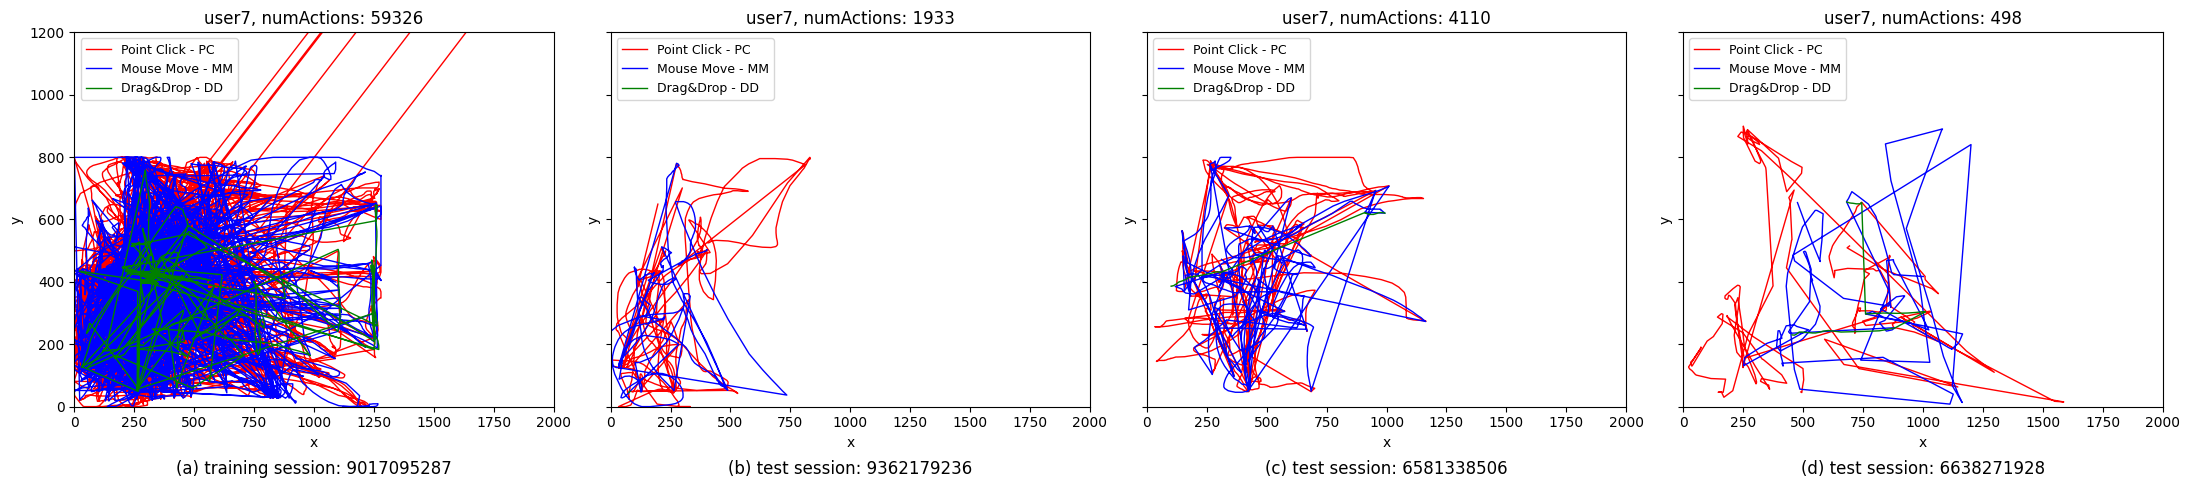

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
# === Config ===
USER_ID = 'user7'
RANDOM_SEED = 42

# === Filter for user7 ===
train_user = train[train['user'] == USER_ID]
test_user = test[test['user'] == USER_ID]

# === Randomly pick sessions ===
np.random.seed(RANDOM_SEED)
train_session = np.random.choice(train_user['session'].unique(), 1)[0]
test_sessions = np.random.choice(test_user['session'].unique(), 3, replace=False)

# === Session order: one train, three test ===
sessions = [(train_session, 'training')] + [(s, 'test') for s in test_sessions]

# === Action color and label map ===
action_colors = {'MM': 'blue', 'PC': 'red', 'DD': 'green'}
action_map = {'MM': 'Mouse Move - MM', 'PC': 'Point Click - PC', 'DD': 'Drag&Drop - DD'}

# === Plotting ===
fig, axs = plt.subplots(1, 4, figsize=(22, 5), sharey=True)

for i, (session_id, session_type) in enumerate(sessions):
    # Pick data
    df = train_user if session_type == 'training' else test_user
    session_df = df[df['session'] == session_id]

    # Clean session label
    short_session_id = session_id.replace("session_", "")

    # Title
    axs[i].set_title(f"user7, numActions: {len(session_df)}")

    # Plot each action type
    for action in session_df['action_label'].unique():
        sub = session_df[session_df['action_label'] == action]
        axs[i].plot(sub['x'], sub['y'],
                    color=action_colors.get(action, 'black'),
                    label=action_map.get(action, action),
                    linewidth=1)

    axs[i].invert_yaxis()
    axs[i].set_xlim([0, 2000])
    axs[i].set_ylim([0, 1200])
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')

    # Subplot label
    subplot_label = chr(ord('a') + i)
    axs[i].text(0.5, -0.18, f"({subplot_label}) {session_type} session: {short_session_id}",
                transform=axs[i].transAxes, ha='center', fontsize=12)

    # Legend in each plot
    axs[i].legend(loc='upper left', fontsize=9)


plt.tight_layout()

fig.savefig("user7_sessions_plot.png", dpi=300, bbox_inches='tight')

plt.show()

Selected session: session_5657866014


/tmp/ipython-input-30-364263388.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(unique_actions))


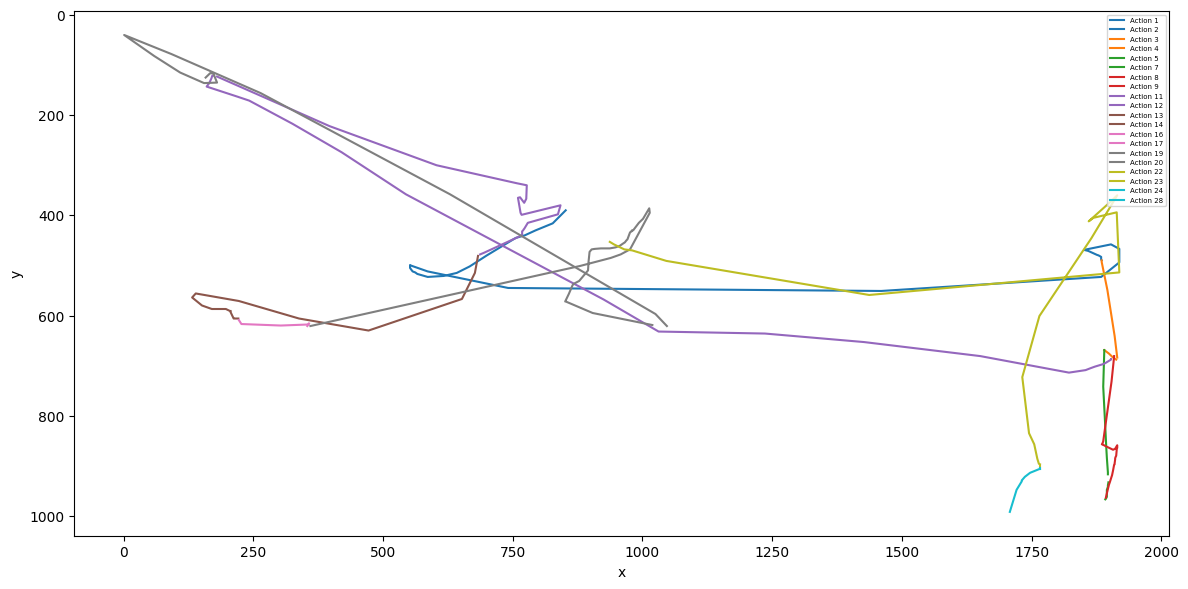

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# === Randomly select a session from train ===
np.random.seed(42)
random_session_id = np.random.choice(train['session'].unique(), 1)[0]

# === Filter the session data ===
session_df = train[train['session'] == random_session_id]
print(f"Selected session: {random_session_id}")

# === Get first 10 unique action_ids (preserving order) ===
first_20_action_ids = session_df['action_id'].drop_duplicates().iloc[:20]

# === Filter only rows belonging to those first 10 actions ===
session_df = session_df[session_df['action_id'].isin(first_20_action_ids)]

# === Set up color map ===
unique_actions = first_20_action_ids.tolist()
colors = cm.get_cmap('tab10', len(unique_actions))

# === Plot ===
fig, ax = plt.subplots(figsize=(12, 6))
for i, aid in enumerate(unique_actions):
    seg = session_df[session_df['action_id'] == aid]
    ax.plot(seg['x'], seg['y'], label=f'Action {aid}', color=colors(i))

ax.invert_yaxis()
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(fontsize=5, loc='upper right')
plt.tight_layout()

# Save figure
fig.savefig("Mouse_Trajectory_First20Actions.png", dpi=300, bbox_inches='tight')
plt.show()

## Number of Action Per User

In [ ]:
def count_sessions_and_actions(df, dataset_name):
    # Count sessions
    session_counts = df.groupby('user')['session'].nunique().reset_index()
    session_counts.rename(columns={'session': 'num_sessions'}, inplace=True)

    # Count total number of unique (session, action_id) pairs per user
    action_counts = (
        df.drop_duplicates(subset=['user', 'session', 'action_id'])
          .groupby('user')
          .size()
          .reset_index(name='num_actions')
    )

    # Merge
    merged = pd.merge(session_counts, action_counts, on='user')

    print(f"\n{dataset_name} - Number of Sessions and Actions per User")
    display(merged.sort_values(by='num_sessions', ascending=False))

# Apply to both train and test datasets
count_sessions_and_actions(train, "Train Dataset")
count_sessions_and_actions(test, "Test Dataset")


Train Dataset - Number of Sessions and Actions per User


,user,num_sessions,num_actions
0,user12,7,11558
3,user20,7,5191
9,user9,7,4273
4,user21,7,6843
8,user7,7,6799
6,user29,7,8815
5,user23,6,6216
2,user16,6,13623
7,user35,5,4942
1,user15,3,3795



Test Dataset - Number of Sessions and Actions per User


,user,num_sessions,num_actions
2,user16,77,3783
0,user12,71,3745
7,user35,63,3660
1,user15,52,3318
6,user29,44,2397
8,user7,42,2029
9,user9,42,1916
4,user21,40,2163
5,user23,35,2050
3,user20,30,1482


In [ ]:
train[['user', 'session', 'action_id']].drop_duplicates().shape[0]

72055

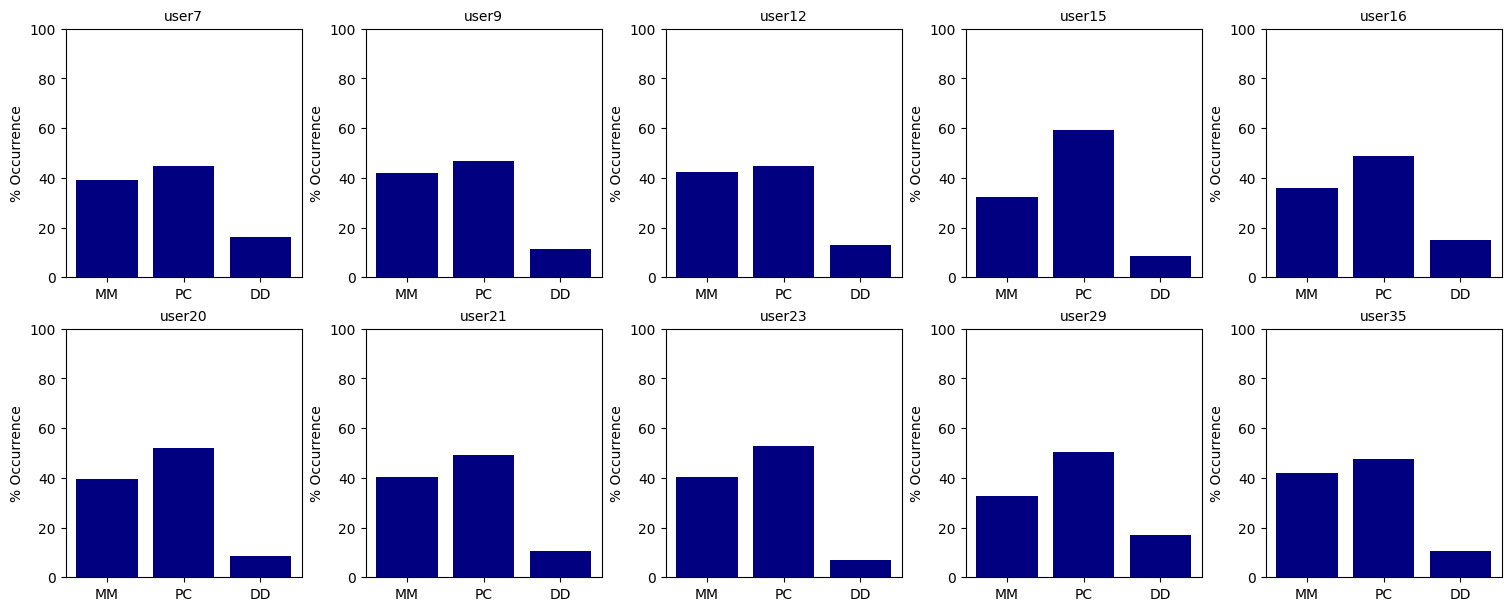

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sorted_user_action_distribution(df, dataset_name):
    # Count number of actions = unique action_ids per user and label
    action_counts = df.groupby(['user', 'action_label'])['action_id'].nunique().reset_index(name='num_actions')

    # Calculate total actions per user for %
    action_counts['percent'] = action_counts.groupby('user')['num_actions'].transform(lambda x: 100 * x / x.sum())

    # Define fixed order of labels
    label_order = ['MM', 'PC', 'DD']
    action_counts['action_label'] = pd.Categorical(action_counts['action_label'], categories=label_order, ordered=True)

    # Define user order (as in your image)
    user_order = [f'user{i}' for i in [7, 9, 12, 15, 16, 20, 21, 23, 29, 35]]
    filtered = action_counts[action_counts['user'].isin(user_order)]
    filtered['user'] = pd.Categorical(filtered['user'], categories=user_order, ordered=True)

    # Plot setup
    fig, axes = plt.subplots(2, 5, figsize=(15, 6), constrained_layout=True)
    axes = axes.flatten()

    for i, user in enumerate(user_order):
        ax = axes[i]
        user_data = filtered[filtered['user'] == user]

        # Ensure all labels are present even if missing in the data
        plot_data = pd.DataFrame({'action_label': label_order})
        plot_data = plot_data.merge(user_data[['action_label', 'percent']], on='action_label', how='left').fillna(0)

        ax.bar(plot_data['action_label'], plot_data['percent'], color='navy')
        ax.set_title(user, fontsize=10)
        ax.set_ylim(0, 100)
        ax.set_ylabel('% Occurrence')
        ax.set_xticks(range(len(label_order)))
        ax.set_xticklabels(label_order)

    fig.savefig("Action Distribution.png", dpi=300, bbox_inches='tight')

    plt.show()

# Apply on your processed DataFrame
plot_sorted_user_action_distribution(train, "Train Dataset")

## Average Session Length

/tmp/ipython-input-15-4128671188.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


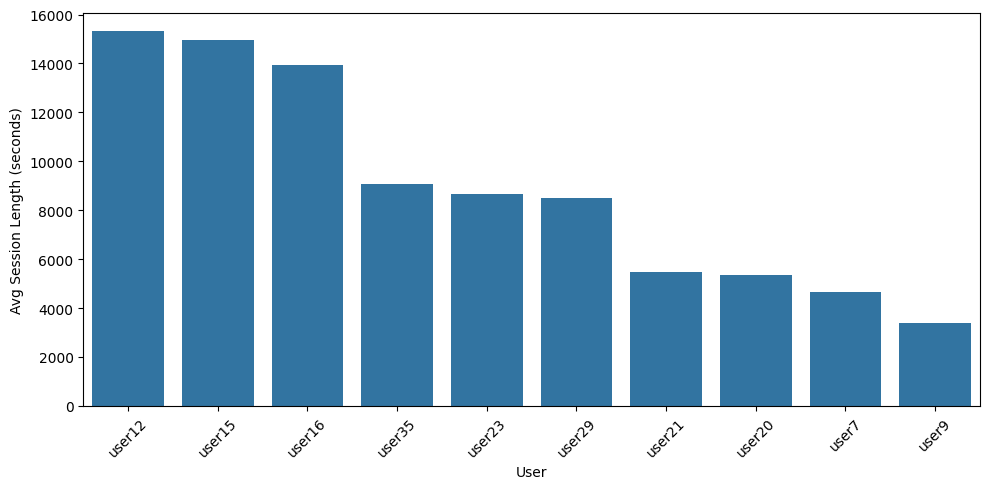

,user,avg_session_length
0,user12,15314.074571
1,user15,14953.564333
2,user16,13934.729667
7,user35,9081.579600
5,user23,8663.058000
6,user29,8493.189000
4,user21,5489.953857
3,user20,5359.851143
8,user7,4678.516857
9,user9,3372.645857


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_avg_session_length_per_user(df):
    # Step 1: Compute session duration = max - min timestamp
    session_durations = (
        df.groupby(['user', 'session'])['client timestamp']
          .agg(session_start='min', session_end='max')
          .reset_index()
    )
    session_durations['session_length'] = session_durations['session_end'] - session_durations['session_start']

    # Step 2: Average session length per user
    avg_session_lengths = (
        session_durations.groupby('user')['session_length']
        .mean()
        .reset_index(name='avg_session_length')
    )

    # Step 3: Plot (with correct fig reference)
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(
        data=avg_session_lengths.sort_values('avg_session_length', ascending=False),
        x='user', y='avg_session_length', ax=ax
    )
    ax.set_ylabel("Avg Session Length (seconds)")
    ax.set_xlabel("User")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    fig.tight_layout()

    # Save the correct figure
    fig.savefig("Average Session Length per User.png", dpi=300, bbox_inches='tight')

    plt.show()

    # Optional: print table
    display(avg_session_lengths.sort_values(by='avg_session_length', ascending=False))

# Apply
plot_avg_session_length_per_user(train)

## Distribution of Action Interval

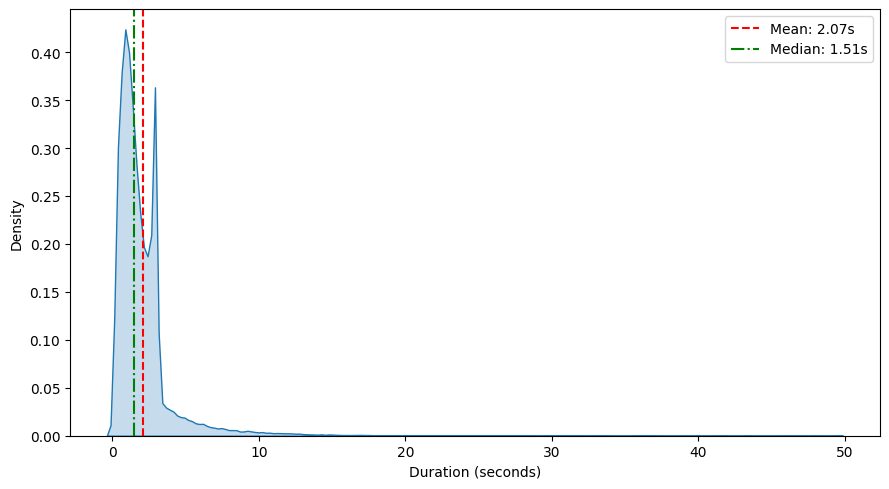

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_kde_action_durations(df, dataset_name):
    # Group by user, session, action_id
    grouped = df.groupby(['user', 'session', 'action_id'])
    durations = grouped['client timestamp'].agg(lambda x: x.max() - x.min()).reset_index()
    durations.rename(columns={'client timestamp': 'duration'}, inplace=True)

    # Filter out extreme outliers
    durations = durations[durations['duration'] < 50]

    # Compute statistics
    mean_duration = durations['duration'].mean()
    median_duration = durations['duration'].median()

    # Plot using explicit figure and axis
    fig, ax = plt.subplots(figsize=(9, 5))
    sns.kdeplot(durations['duration'], bw_adjust=0.5, fill=True, ax=ax)

    # Mean & median lines
    ax.axvline(mean_duration, color='red', linestyle='--', label=f'Mean: {mean_duration:.2f}s')
    ax.axvline(median_duration, color='green', linestyle='-.', label=f'Median: {median_duration:.2f}s')

    # Labels and styling
    ax.set_xlabel('Duration (seconds)')
    ax.set_ylabel('Density')
    ax.legend()
    fig.tight_layout()

    # Save the figure
    fig.savefig("Action Duration Distribution(KDE).png", dpi=300, bbox_inches='tight')

    plt.show()

# Usage
plot_kde_action_durations(train, "Train Dataset")

## Time Distribution

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_sorted = train.sort_values(by=['user', 'session', 'client timestamp'])
df_sorted['dt'] = df_sorted.groupby(['user', 'session'])['client timestamp'].diff()

dt_values = df_sorted['dt'].dropna()

# Compute percentiles from 1 to 100
percentiles = np.percentile(dt_values, np.arange(1, 101))

# Convert to DataFrame for better display
percentile_df = pd.DataFrame({
    'Percentile': np.arange(1, 101),
    'dt (seconds)': percentiles
})

# Show the result
import pandas as pd
from IPython.display import display
display(percentile_df)

,Percentile,dt (seconds)
0,1,0.000
1,2,0.000
2,3,0.000
3,4,0.000
4,5,0.000
...,...,...
95,96,0.452
96,97,0.609
97,98,0.905
98,99,1.997


In [ ]:
summary_percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99, 100]
summary_values = np.percentile(dt_values, summary_percentiles)

summary_df = pd.DataFrame({
    'Percentile': summary_percentiles,
    'dt (seconds)': summary_values
})

display(summary_df)

,Percentile,dt (seconds)
0,1,0.000
1,5,0.000
2,10,0.000
3,25,0.015
4,50,0.031
5,75,0.110
6,90,0.188
7,95,0.359
8,99,1.997
9,100,6757.027


## Pause Time

### Per User

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# --- Function to compute better pause ratio ---
def compute_better_pause_ratio(group, time_thresh=0.5, dist_thresh=2):
    group = group.sort_values('client timestamp')
    t = group['client timestamp'].values
    x = group['x'].values
    y = group['y'].values

    if len(t) < 2:
        return np.nan

    dt = np.diff(t)
    dx = np.diff(x)
    dy = np.diff(y)
    dist = np.sqrt(dx**2 + dy**2)

    is_pause = (dt > time_thresh) & (dist < dist_thresh)
    return np.sum(is_pause) / len(dt)

# --- Loop through all actions in train ---
pause_ratios = []

grouped = train.groupby(['user', 'session', 'action_id'])

for (user, session, action_id), group in tqdm(grouped, desc="Computing refined pause ratios"):
    ratio = compute_better_pause_ratio(group)
    pause_ratios.append({
        'user': user,
        'session': session,
        'action_id': action_id,
        'action_label': group['action_label'].iloc[0],
        'pause_ratio': ratio
    })

# --- Collect results in DataFrame ---
pause_df = pd.DataFrame(pause_ratios)

# --- Summary stats ---
print("\nSummary of Better Pause Ratios:")
print(pause_df['pause_ratio'].describe())

Computing refined pause ratios: 100%|██████████| 72055/72055 [00:29<00:00, 2464.74it/s]



Summary of Better Pause Ratios:
count    72055.000000
mean         0.015820
std          0.050337
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: pause_ratio, dtype: float64


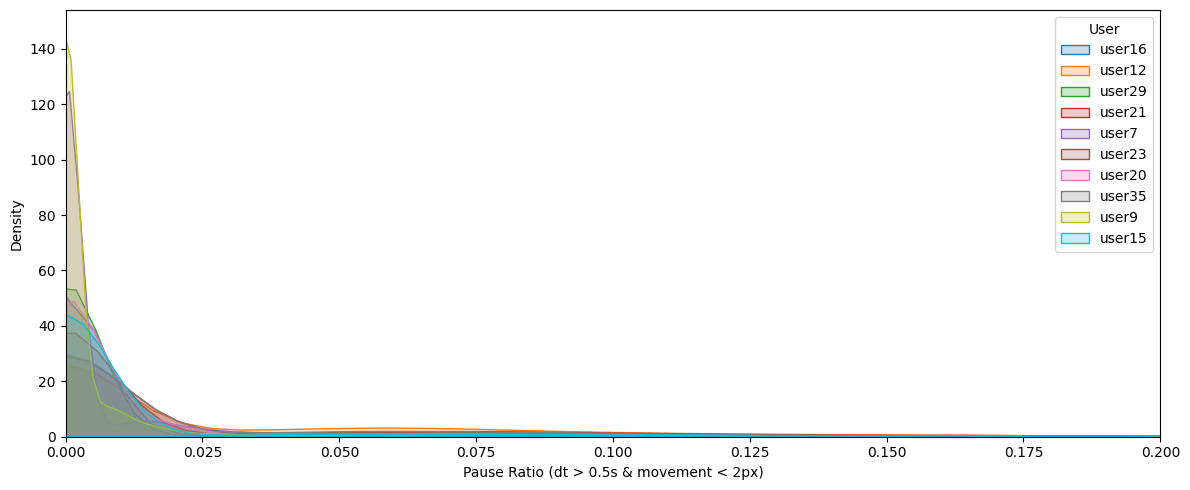

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_pause_ratio_per_user_zoomed(pause_df, users=None, x_max=0.15):
    if users is None:
        top_users = pause_df['user'].value_counts().nlargest(10).index.tolist()
    else:
        top_users = users

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 5))

    for user in top_users:
        subset = pause_df[pause_df['user'] == user]
        sns.kdeplot(
            subset['pause_ratio'].dropna(),
            label=user, fill=True, common_norm=False, ax=ax
        )

    ax.set_xlabel("Pause Ratio (dt > 0.5s & movement < 2px)")
    ax.set_ylabel("Density")
    ax.legend(title='User')
    ax.set_xlim(0, x_max)
    fig.tight_layout()

    # Save the correct figure
    fig.savefig("Pause Ratio Distribution per User.png", dpi=300, bbox_inches='tight')

    plt.show()

# Use the function
plot_pause_ratio_per_user_zoomed(pause_df, x_max=0.2)

# Feature Extraction

## Feature Descriptions (with Calculation Explanation)

Each feature below is extracted from the x/y mouse trajectory and timestamp (`client timestamp`) of a single action (defined by `user`, `session`, and `action_id`).

### Velocity
- `mean_vx`, `std_vx`, `min_vx`, `max_vx`: Statistics of horizontal velocity, calculated as `vx = dx / dt`
- `mean_vy`, `std_vy`, `min_vy`, `max_vy`: Statistics of vertical velocity, calculated as `vy = dy / dt`
- `mean_v`, `std_v`, `min_v`, `max_v`: Statistics of overall speed, computed as `v = sqrt(vx² + vy²)`

### Acceleration & Jerk
- `mean_a`, `std_a`, `min_a`, `max_a`: Acceleration stats, computed as the change in speed over time: `a = diff(v) / dt[1:]`
- `mean_j`, `std_j`, `min_j`, `max_j`: Jerk stats, which is the rate of change of acceleration: `j = diff(a) / dt[2:]`

### Angular Features
- `mean_omega`, `std_omega`, `min_omega`, `max_omega`: Angular velocity stats (`omega = diff(angle) / dt`)
- `mean_curv`, `std_curv`, `min_curv`, `max_curv`: Curvature stats, calculated as `curvature = angle change / path length segment`

### Time & Distance
- `elapsed_time`: Total time of the action: `t[-1] - t[0]`
- `trajectory_length`: Sum of Euclidean distances between consecutive points
- `dist_end_to_end`: Straight-line distance from the first to last point
- `direction`: Coarse direction (1–8), based on angle between first and last point
- `straightness`: `dist_end_to_end / trajectory_length`
- `num_points`: Number of points in the action

### Shape & Complexity
- `sum_of_angles`: Sum of absolute angular changes (`sum(abs(diff(theta)))`)
- `largest_deviation`: Max perpendicular distance from any point to the straight line from start to end
- `num_sharp_angles`: Number of angle changes smaller than a small threshold (`< 0.0005 radians`)

### Timing
- `a_beg_time`: Time from start until acceleration becomes non-positive, measured from `t[0]` to first `a <= 0`

### Pause Behavior
- `pause_ratio`: Ratio of pauses where dt > 0.5s and distance moved < 2px

### Metadata
- `user`: Unique user identifier
- `session`: Unique session ID
- `action_id`: Index of the action in the session
- `action_label`: Label of the action (`PC`, `DD`, `MM`)

> Preprocessing note: we filtered out extreme values where `dt <= 1ms` or `dt >= 1s` to avoid velocity spikes and idle gaps.

In [ ]:
import numpy as np
import pandas as pd

def extract_mouse_features(action_df):
    x = action_df['x'].values
    y = action_df['y'].values
    t = action_df['client timestamp'].values

    # --- Diff and filter dt ---
    dx = np.diff(x)
    dy = np.diff(y)
    dt = np.diff(t)

    # Filter out extreme/suspicious dt values
    valid = (dt > 0.001) & (dt < 1.0)  # keep only 1ms < dt < 1s
    dx = dx[valid]
    dy = dy[valid]
    dt = dt[valid]

    if len(dx) < 1 or len(dt) < 1:
        return None

    # --- Velocity ---
    vx = dx / dt
    vy = dy / dt
    v = np.sqrt(vx**2 + vy**2)

    # --- Acceleration and Jerk ---
    a = np.diff(v) / dt[1:] if len(v) > 1 else np.array([0])
    j = np.diff(a) / dt[2:] if len(a) > 1 else np.array([0])

    # --- Angular Velocity ---
    theta = np.arctan2(dy, dx) if len(dx) > 0 else np.array([0])
    dtheta = np.diff(theta) if len(theta) > 1 else np.array([0])
    omega = dtheta / dt[1:] if len(dt) > 1 else np.array([0])

    # --- Curvature ---
    segment_lengths = np.sqrt(dx**2 + dy**2)
    s = np.cumsum(np.insert(segment_lengths, 0, 0))
    ds = np.diff(s)
    ds[ds == 0] = 1e-5
    curvature = dtheta / ds[1:] if len(ds) > 1 else np.array([0])

    # --- Geometry ---
    dist_end_to_end = np.linalg.norm([x[-1] - x[0], y[-1] - y[0]]) if len(x) > 1 else 0
    straightness = dist_end_to_end / s[-1] if s[-1] > 0 else 0

    dx_total = x[-1] - x[0] if len(x) > 1 else 0
    dy_total = y[-1] - y[0] if len(y) > 1 else 0
    angle = np.arctan2(dy_total, dx_total)
    direction = int(np.floor((angle + np.pi) / (np.pi / 4))) % 8 + 1

    # --- Path Complexity ---
    sum_of_angles = np.sum(np.abs(dtheta))

    def point_line_distance(px, py, x0, y0, x1, y1):
        num = abs((y1 - y0) * px - (x1 - x0) * py + x1 * y0 - y1 * x0)
        den = np.sqrt((y1 - y0)**2 + (x1 - x0)**2)
        return num / den if den != 0 else 0

    deviations = [point_line_distance(px, py, x[0], y[0], x[-1], y[-1]) for px, py in zip(x, y)] if len(x) > 1 else [0]
    largest_deviation = max(deviations)

    sharp_angle_threshold = 0.0005
    num_sharp_angles = np.sum(np.abs(dtheta) < sharp_angle_threshold)

    # --- Deceleration Time ---
    a_time = t[2:][np.where(a[1:] <= 0)[0]] if len(a) > 1 else []
    a_beg_time = (a_time[0] - t[0]) if len(a_time) > 0 else t[-1] - t[0]

    # --- Refined Pause Ratio ---
    full_dt = np.diff(t)
    full_dx = np.diff(x)
    full_dy = np.diff(y)
    full_dist = np.sqrt(full_dx**2 + full_dy**2)
    pause_mask = (full_dt > 0.5) & (full_dist < 2)
    pause_ratio = np.sum(pause_mask) / len(full_dt) if len(full_dt) > 0 else 0

    return {
        'mean_vx': np.mean(vx), 'std_vx': np.std(vx), 'min_vx': np.min(vx), 'max_vx': np.max(vx),
        'mean_vy': np.mean(vy), 'std_vy': np.std(vy), 'min_vy': np.min(vy), 'max_vy': np.max(vy),
        'mean_v': np.mean(v), 'std_v': np.std(v), 'min_v': np.min(v), 'max_v': np.max(v),
        'mean_a': np.mean(a), 'std_a': np.std(a), 'min_a': np.min(a), 'max_a': np.max(a),
        'mean_j': np.mean(j), 'std_j': np.std(j), 'min_j': np.min(j), 'max_j': np.max(j),
        'mean_omega': np.mean(omega), 'std_omega': np.std(omega), 'min_omega': np.min(omega), 'max_omega': np.max(omega),
        'mean_curv': np.mean(curvature), 'std_curv': np.std(curvature), 'min_curv': np.min(curvature), 'max_curv': np.max(curvature),
        'elapsed_time': t[-1] - t[0],
        'trajectory_length': s[-1],
        'dist_end_to_end': dist_end_to_end,
        'direction': direction,
        'straightness': straightness,
        'num_points': len(x),
        'sum_of_angles': sum_of_angles,
        'largest_deviation': largest_deviation,
        'num_sharp_angles': num_sharp_angles,
        'a_beg_time': a_beg_time,
        'pause_ratio': pause_ratio
    }

In [ ]:
# -------- Step 2: Apply to all actions --------
def extract_all_action_features(df):
    feature_rows = []
    grouped = df.groupby(['user', 'session', 'action_id'])

    for (user, session, action_id), group in grouped:
        group = group.sort_values('client timestamp')
        features = extract_mouse_features(group)
        if features:
            features.update({
                'user': user,
                'session': session,
                'action_id': action_id,
                'action_label': group['action_label'].iloc[0]
            })
            feature_rows.append(features)

    return pd.DataFrame(feature_rows)

# Train

In [ ]:
train_df_feature = extract_all_action_features(train)

NameError: name 'extract_all_action_features' is not defined

In [ ]:
train_df_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72029 entries, 0 to 72028
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   mean_vx            72029 non-null  float64
 1   std_vx             72029 non-null  float64
 2   min_vx             72029 non-null  float64
 3   max_vx             72029 non-null  float64
 4   mean_vy            72029 non-null  float64
 5   std_vy             72029 non-null  float64
 6   min_vy             72029 non-null  float64
 7   max_vy             72029 non-null  float64
 8   mean_v             72029 non-null  float64
 9   std_v              72029 non-null  float64
 10  min_v              72029 non-null  float64
 11  max_v              72029 non-null  float64
 12  mean_a             72029 non-null  float64
 13  std_a              72029 non-null  float64
 14  min_a              72029 non-null  float64
 15  max_a              72029 non-null  float64
 16  mean_j             720

In [ ]:
train_df_feature.to_csv('/content/drive/MyDrive/Thesis/Code-and-Files/train_df_feature.csv', index=False)

# Test

In [ ]:
test.head()

,record timestamp,client timestamp,button,state,x,y,user,session,is_illegal,action_label,action_id
0,19.818,19.828,NoButton,Move,391,516,user15,session_0003960194,1.0,MM,1
1,19.939,19.843,NoButton,Move,388,516,user15,session_0003960194,1.0,MM,1
2,19.939,19.859,NoButton,Move,383,516,user15,session_0003960194,1.0,MM,1
3,19.939,19.874,NoButton,Move,377,516,user15,session_0003960194,1.0,MM,1
4,19.939,19.890,NoButton,Move,369,516,user15,session_0003960194,1.0,MM,1


In [ ]:
def extract_all_action_features(df):
    feature_rows = []
    grouped = df.groupby(['user', 'session', 'action_id'])

    for (user, session, action_id), group in grouped:
        group = group.sort_values('client timestamp')
        features = extract_mouse_features(group)
        if features:
            features.update({
                'user': user,
                'session': session,
                'action_id': action_id,
                'action_label': group['action_label'].iloc[0],
                'is_illegal': group['is_illegal'].iloc[0]  # <- Add this line
            })
            feature_rows.append(features)

    return pd.DataFrame(feature_rows)

In [ ]:
test_df_feature = extract_all_action_features(test)

In [ ]:
test_df_feature.to_csv('/content/drive/MyDrive/Thesis/Code-and-Files/test_df_feature.csv', index=False)

# Explore Features

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import seaborn as sns

# Load train and test
train_df = pd.read_csv('/content/drive/MyDrive/Thesis/Code-and-Files/train_df_feature.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Thesis/Code-and-Files/test_df_feature.csv')

In [2]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72029 entries, 0 to 72028
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   mean_vx            72029 non-null  float64
 1   std_vx             72029 non-null  float64
 2   min_vx             72029 non-null  float64
 3   max_vx             72029 non-null  float64
 4   mean_vy            72029 non-null  float64
 5   std_vy             72029 non-null  float64
 6   min_vy             72029 non-null  float64
 7   max_vy             72029 non-null  float64
 8   mean_v             72029 non-null  float64
 9   std_v              72029 non-null  float64
 10  min_v              72029 non-null  float64
 11  max_v              72029 non-null  float64
 12  mean_a             72029 non-null  float64
 13  std_a              72029 non-null  float64
 14  min_a              72029 non-null  float64
 15  max_a              72029 non-null  float64
 16  mean_j             720

## ANOVA

In [8]:
from sklearn.feature_selection import f_classif
import pandas as pd

# === Step 1: Define feature list ===
exclude_cols = ['user', 'session', 'action_id', 'action_label']
features = [col for col in train_df.columns if col not in exclude_cols]

# === Step 2: Prepare X (feaatures) and y (target user) ===
X = train_df[features]
y = train_df['user']

# === Step 3: Apply ANOVA F-test ===
f_vals, p_vals = f_classif(X, y)

# === Step 4: Store results in DataFrame ===
anova_df = pd.DataFrame({
    'feature': features,
    'f_value': f_vals,
    'p_value': p_vals
}).sort_values(by='f_value', ascending=False)

# === Step 5: Show top 10 features ===
anova_df

,feature,f_value,p_value
22,min_omega,5011.599267,0.000000e+00
23,max_omega,4787.429869,0.000000e+00
21,std_omega,4001.688645,0.000000e+00
33,num_points,3935.215282,0.000000e+00
36,num_sharp_angles,2879.317525,0.000000e+00
18,min_j,2434.239257,0.000000e+00
34,sum_of_angles,942.405791,0.000000e+00
37,a_beg_time,585.995869,0.000000e+00
28,elapsed_time,394.943488,0.000000e+00
25,std_curv,272.921200,0.000000e+00


In [4]:
from scipy.stats import f

# Example values
k = train_df['user'].nunique()
n = len(train_df)
df_between = k - 1
df_within = n - k

alpha = 0.05
f_critical = f.ppf(1 - alpha, df_between, df_within)

print(f"Critical F-value (α = 0.05): {f_critical:.4f}")

Critical F-value (α = 0.05): 1.8800


## RandomForest

<Axes: >

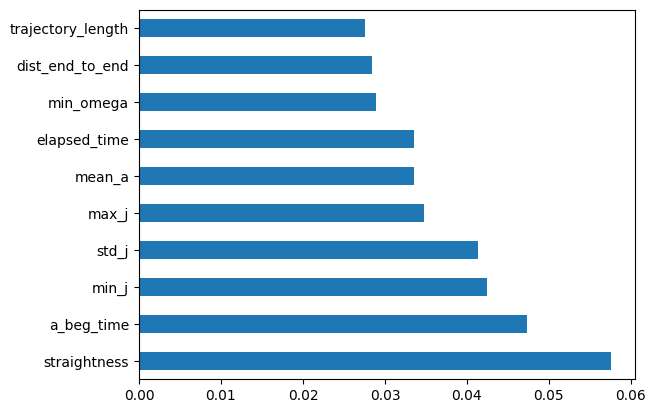

In [5]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(train_df[features], train_df['user'])

importances = pd.Series(clf.feature_importances_, index=features)
importances.nlargest(10).plot(kind='barh')

In [7]:
importances.sort_values(ascending=False)

,0
straightness,0.057615
a_beg_time,0.047301
min_j,0.042406
std_j,0.041310
max_j,0.034739
mean_a,0.033565
elapsed_time,0.033515
min_omega,0.028919
dist_end_to_end,0.028394
trajectory_length,0.027614


## Mutual Info

In [9]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(train_df[features], train_df['user'], discrete_features=False)
mi_df = pd.DataFrame({'feature': features, 'mi': mi_scores})
mi_df.sort_values(by='mi', ascending=False)

,feature,mi
37,a_beg_time,0.422640
22,min_omega,0.373744
19,max_j,0.367864
23,max_omega,0.364995
18,min_j,0.360124
17,std_j,0.355932
3,max_vx,0.346525
6,min_vy,0.339402
7,max_vy,0.337767
2,min_vx,0.323947
